In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

In [2]:
# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/global/cscratch1/sd/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000059.fits
Y3_GOLD_2_0_STRIPE82_000006.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000126.fits
Y3_GOLD_2_0_STRIPE82_000080.fits
Y3_GOLD_2_0_STRIPE82_000003.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000037.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000134.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000066.fits
Y3_GOLD_2_0_STRIPE82_000030.fits
Y3_GOLD_2_0_STRIPE82_000116.fits
Y3_GOLD_2_0_STRIPE82_000092.fits
Y3_GOLD_2_0_STRIPE82_000120.fits
Y3_GOLD_2_0_STRIPE82_000035.fits
Y3_GOLD_2_0_STRIPE82_000129.fits
Y3_GOLD_2_0_STRIPE82_000112.fits
Y3_GOLD_2_0_STRIPE82_000023.fits
Y3_GOLD_2_0_STRIPE82_000083.fits
Y3_GOLD_2_0_STRIPE82_000106.fits
Y3_GOLD_2_0_STRIPE82_000034.fits
Y3_GOLD_2_0_STRIPE82_000014.fits
Y3_GOLD_2_0_STRIPE82_000004.fits
Y3_GOLD_2_0_STRIPE82_000013.fits
Y3_GOLD_2_0_STRIPE82_000090.fits
Y3_GOLD_2_0_STRIPE82_000101.fits
Y3_GOLD_2_0_STRIPE82_000021.fits
Y3_GOLD_2_0_STRIPE82_

In [3]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/global/cscratch1/sd/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)

9547728
7950260


In [4]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/global/cscratch1/sd/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [13]:
#check pickle file:
import pickle
f = open('../output/test/fitting/gauss_cmass_testy3.pkl', 'rb')
dmass_pickle = pickle.load(f, encoding="bytes")
g = open('../output/test/fitting/gauss_no_testy3.pkl', 'rb')
dmass_nopickle = pickle.load(g, encoding="bytes")

#Running pickle

import pickle

# Su's pickle file: changing from 'b'
outdir = '../output/test/fitting/'
dmass_pickle = outdir+'gauss_cmass_testy3.pkl'  # cmass
dmass_no_pickle = outdir+'gauss_no_testy3.pkl' # noncmass
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(dmass_pickle, 'rb')
g = open(dmass_no_pickle, 'rb')

clf_dmass = pickle.load(f, encoding="latin1")
clf_dmass = clf_dmass['retval']
clf_nodmass = pickle.load(g, encoding="latin1")
clf_nodmass = clf_nodmass['retval']
X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)
print(clf_dmass)
print(clf_nodmass)

In [14]:
# FIGURE 3

#clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_testy3.pkl')               
#clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_testy3.pkl')

#call in catalogs
# Assigning CMASS probabilities to Gold Y3 in Stripe 82 Training/Testing Region.
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

mask = (gold_st82['RA']>330) & (gold_st82['RA']<360)
mask = mask & (gold_st82['DEC']>-5) & (gold_st82['DEC']<5)
gold_st82_train = gold_st82[mask]

mask_cmass = (train_sample['RA']<330) & (train_sample['RA']<360)
mask_cmass = mask_cmass & (train_sample['DEC']>-5) & (train_sample['DEC']<5)
cmass_train1 = train_sample[mask_cmass]
mg1, mg2, _ = esutil.htm.HTM(10).match(cmass_train1['RA'], cmass_train1['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

clean_cmass_data_des = clean_cmass_data_des_train

cmass_fraction = clean_cmass_data_des.size *1./gold_st82_train.size

# Validation regions for DES:
mask1 = (gold_st82['RA']<30)
mask1 = mask1 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v1 = gold_st82[mask1]

mask2 =(gold_st82['RA']>15)&(gold_st82['RA']<41)
mask2 = mask2 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v2 = gold_st82[mask2]

mask3 =(gold_st82['RA']>24)&(gold_st82['RA']<45)|((gold_st82['RA']<330)&(gold_st82['RA']>300))
mask3 = mask3 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v3 = gold_st82[mask3]

# Validation regions for CMASS:
mask1_cmass = (train_sample['RA']<30)
mask1_cmass = mask1_cmass & (train_sample['DEC']>-10) & (train_sample['DEC']<10)
cmass_v1 = train_sample[mask1_cmass]
mg1, mg2, _ = esutil.htm.HTM(10).match(cmass_v1['RA'], cmass_v1['DEC'], gold_st82_v1['RA'], \
                                         gold_st82_v1['DEC'],2./3600, maxmatch=1)
cmass_mask1 = np.zeros(gold_st82_v1.size, dtype=bool)
cmass_mask1[mg2] = 1
clean_cmass_data_des_v1, nocmass_v1 = gold_st82_v1[cmass_mask1], gold_st82_v1[~cmass_mask1]

mask2_cmass = (train_sample['RA']>15) & (train_sample['DEC']<41)
mask2_cmass = mask2_cmass & (train_sample['DEC']>-10) & (train_sample['DEC']<10)
cmass_v2 = train_sample[mask2_cmass]
mg1, mg2, _ = esutil.htm.HTM(10).match(cmass_v2['RA'], cmass_v2['DEC'], gold_st82_v2['RA'], \
                                         gold_st82_v2['DEC'],2./3600, maxmatch=1)
cmass_mask2 = np.zeros(gold_st82_v2.size, dtype=bool)
cmass_mask2[mg2] = 1
clean_cmass_data_des_v2, nocmass_v2 = gold_st82_v2[cmass_mask2], gold_st82_v2[~cmass_mask2]

mask3_cmass = (train_sample['RA']>24) & (train_sample['DEC']<45)|((train_sample['RA']<330)&(train_sample['RA']>300))
mask3_cmass = mask3_cmass & (train_sample['DEC']>-10) & (train_sample['DEC']<10)
cmass_v3 = train_sample[mask3_cmass]
mg1, mg2, _ = esutil.htm.HTM(10).match(cmass_v3['RA'], cmass_v3['DEC'], gold_st82_v3['RA'], \
                                         gold_st82_v3['DEC'],2./3600, maxmatch=1)
cmass_mask3 = np.zeros(gold_st82_v3.size, dtype=bool)
cmass_mask3[mg2] = 1
clean_cmass_data_des_v3, nocmass_v3 = gold_st82_v3[cmass_mask3], gold_st82_v3[~cmass_mask3]


# now:
cmass_train = clean_cmass_data_des_train
#cmass_val1 = clean_cmass_data_des[~mask_half]

In [15]:
#takes 1 percent of validation samples:
print(gold_st82_v1.size)
gold_v1_random_ind = np.random.choice(np.arange(gold_st82_v1.size), size = int(gold_st82_v1.size/100))
gold_v1_random = gold_st82_v1[gold_v1_random_ind]
print(gold_v1_random.size)

print(gold_st82_v2.size)
gold_v2_random_ind = np.random.choice(np.arange(gold_st82_v2.size), size = int(gold_st82_v2.size/100))
gold_v2_random = gold_st82_v2[gold_v2_random_ind]
print(gold_v2_random.size)

print(gold_st82_v3.size)
gold_v3_random_ind = np.random.choice(np.arange(gold_st82_v3.size), size = int(gold_st82_v3.size/100))
gold_v3_random = gold_st82_v3[gold_v3_random_ind]
print(gold_v3_random.size)

3508697
35086
3534397
35343
3889950
38899


cmass fraction:  0.0
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [1.13317587e-01 6.84949833e+00 1.36019417e+01 1.73333333e+01
 2.75128205e+01 3.02413793e+01 3.03793103e+01 4.12500000e+01
 3.17307692e+01 5.63333333e+01 6.05000000e+01 5.72000000e+01
 6.64615385e+01 8.92000000e+01 7.42307692e+01 8.63076923e+01
 8.07500000e+01 8.51111111e+01 9.45000000e+01 1.33033333e+02]
frac.size 20
frac err 20


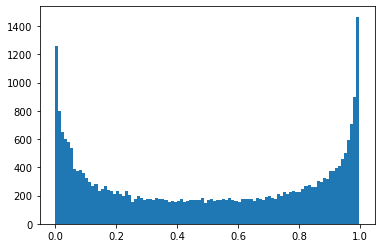

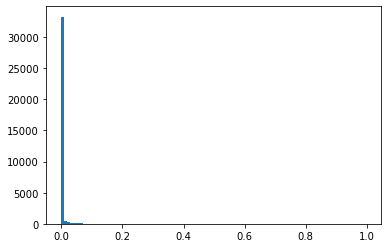

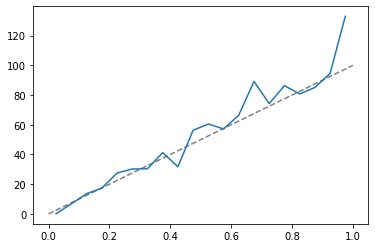

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

print('cmass fraction: ', cmass_fraction)
#(Validation 1) Figure 3
clean_dmass_prob1 = assignCMASSProb(clean_cmass_data_des_v1, clf_dmass, clf_nodmass, 
                     cmass_fraction =0.007604481166144398
, 
                     mag=mag, err=err, filter=filter )
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82_real1 = clean_dmass_prob1 # actual CMASS galaxies in val set

# all calculated DMASS for validation sets:
dmass_st82_val1 = assignCMASSProb(gold_v1_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = 0.007604481166144398
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real1['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val1['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real1['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val1['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,100], ls='--', color='grey')

fig.savefig('test_histo.pdf')

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [  0.11187837   6.54662379  11.92622951  16.47222222  24.51162791
  28.67647059  43.66666667  32.07407407  30.5         43.73684211
  61.76923077  42.85        43.35        71.15384615  77.07692308
  60.77777778  70.94444444 104.66666667  86.12        93.        ]


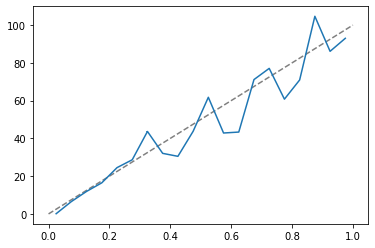

In [19]:
#(Validation 2) Figure 3

clean_dmass_prob2 = assignCMASSProb(clean_cmass_data_des_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction =0.007604481166144398
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real2 = clean_dmass_prob2

dmass_st82_val2 = assignCMASSProb(gold_v2_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = 0.007604481166144398
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real2['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val2['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,100], ls='--', color='grey')

fig.savefig('test_histo2.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [  0.10831274   6.53896104  13.46846847  18.49230769  22.8
  27.28571429  29.83870968  45.73684211  36.95652174  39.95
  61.84615385  53.125       71.5         58.9375      83.41666667
  55.26315789  60.15        60.36       106.05        79.2745098 ]


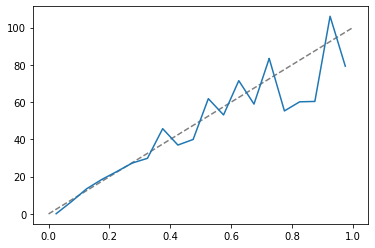

In [20]:
#(Validation 3) Figure 3

clean_dmass_prob3 = assignCMASSProb(clean_cmass_data_des_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction =0.007604481166144398
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real3 = clean_dmass_prob3 

dmass_st82_val3 = assignCMASSProb(gold_v3_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = 0.007604481166144398
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real3['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val3['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,100], ls='--', color='grey')

fig.savefig('test_histo3.pdf')

In [ ]:
# save the samples. 
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_st82_val1.fits', dmass_st82_val1, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val2.fits', dmass_st82_val2, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val3.fits', dmass_st82_val3, overwrite=True)